In [4]:
import sys
from pathlib import Path
import os
sys.path.append(os.path.join(Path.cwd().parent, 'src')) 
sys.path.append(os.path.join(Path.cwd().parent, 'src', 'util')) 
from util.api_call import load_api_vars

# documents = [
#     "The Mediterranean diet emphasizes fish, olive oil, and vegetables, believed to reduce chronic diseases.",
#     "Photosynthesis in plants converts light energy into glucose and produces essential oxygen.",
#     "20th-century innovations, from radios to smartphones, centered on electronic advancements.",
#     "Rivers provide water, irrigation, and habitat for aquatic species, vital for ecosystems.",
#     "Apple’s conference call to discuss fourth fiscal quarter results and business updates is scheduled for Thursday, November 2, 2023 at 2:00 p.m. PT / 5:00 p.m. ET.",
#     "Shakespeare's works, like 'Hamlet' and 'A Midsummer Night's Dream,' endure in literature."
# ]

vo = load_api_vars()
# This will automatically use the environment variable VOYAGE_API_KEY.
# Alternatively, you can use vo = voyageai.Client(api_key="<your secret key>")

# Embed the documents
# documents_embeddings = vo.embed(
#     documents, model="voyage-large-2", input_type="document"
# ).embeddings

## Data Processing

In [20]:
import pandas as pd
data = pd.read_excel("../data/d.xls")
abstract = data['Abstract']
title = data['Article Title']

combine = title.str.cat(abstract, sep=' ')
combine = combine.to_list()

["Does entrepreneurship education in the first year of higher education develop entrepreneurial intentions? The role of learning and inspiration Drawing on entrepreneurship education (EE) theory, this article examines the role of learning and inspiration in developing students' entrepreneurial intentions in the First Year in Higher Education. This addresses the paucity of research on early university experiences of EE and their influence on entrepreneurial intentions. Using a longitudinal survey of business students at a British university, the authors identify four scenarios related to the participation/non-participation in EE and subsequent increase or decrease of entrepreneurial intentions. A sub-set of those surveyed are interviewed (n=49) to better understand how their university experience has influenced their entrepreneurial intentions. Findings suggest that the influence of EE is variable, in some cases even leading to a decrease in entrepreneurial intentions. The results contr

In [23]:
batch_size = 128
embeddings = []
for i in range(0, len(combine), batch_size):
    embeddings += vo.embed(combine[i:i + batch_size], model="voyage-large-2", input_type="document").embeddings

In [43]:
len(embeddings[0])

1536

In [24]:
len(embeddings)

452

In [47]:
combine = pd.DataFrame(combine)
combine['v_embedding'] = embeddings

In [57]:
df = pd.DataFrame({'embeddings': embeddings})

In [52]:
combine.to_excel("../data/embed.xlsx")

## K-Means

In [37]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score

In [69]:
combine['v_embedding'] = combine['v_embedding'].apply(np.array)

In [66]:
combine.drop(['v-embedding'],inplace=True, axis=1)
combine

,0,v_embedding
0,Does entrepreneurship education in the first y...,"[-0.008451409637928009, 0.0033586297649890184,..."
1,Adapting to constructivist approaches to entre...,"[0.014256583526730537, 0.004288913682103157, 0..."
2,Active entrepreneurship education and the impa...,"[0.009077167138457298, 0.02005642093718052, 0...."
3,Nurturing Entrepreneurial Spirit Through Integ...,"[-0.01472783088684082, 0.01929645612835884, 0...."
4,Developing entrepreneurial behaviours in the C...,"[-0.00040966836968436837, -0.00694393552839756..."
...,...,...
447,The effect of entrepreneur mentoring and its d...,"[-0.0062180496752262115, 0.0036392933689057827..."
448,What's new in the research on agricultural ent...,"[-0.011482832953333855, 0.0021173979621380568,..."
449,Towards a more integrated view of entrepreneur...,"[-0.019980620592832565, 0.019933383911848068, ..."
450,The formation of youth entrepreneurial intenti...,"[-0.009015019983053207, 0.025102421641349792, ..."


In [80]:
def calculate_silhouette_scores(data_matrix, min_clusters=3, max_clusters=15):
    cluster_results_km = pd.DataFrame(columns=['k', 'score'])
    
    for k in tqdm(range(min_clusters, max_clusters + 1)):
        km_model = KMeans(n_clusters=k, init='k-means++', random_state=42)
        y = km_model.fit_predict(data_matrix)
        silhouette = silhouette_score(data_matrix, y)
        dic={'k': [k], 'score': [silhouette]}
        cluster_results_km=pd.concat([cluster_results_km, pd.DataFrame(dic)])    
    return cluster_results_km

def find_optimal_cluster(cluster_results):
    cluster_results = cluster_results.reset_index(drop=True)
    optimal_cluster = cluster_results['score'].idxmax()
    optimal_cluster = cluster_results['k'].iloc[optimal_cluster]
    return optimal_cluster

In [81]:
matrix = np.vstack(combine['v_embedding'])


cluster_results_km = calculate_silhouette_scores(matrix)
num_cluster = find_optimal_cluster(cluster_results_km)

print("Optimal number of clusters:", num_cluster)
print(cluster_results_km.loc[cluster_results_km['k'] == num_cluster])

  0%|          | 0/13 [00:00<?, ?it/s]

/Users/yangzejia/anaconda3/envs/text/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_17593/2306006225.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_results_km=pd.concat([cluster_results_km, pd.DataFrame(dic)])
/Users/yangzejia/anaconda3/envs/text/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yangzejia/anaconda3/envs/te

Optimal number of clusters: 3
   k     score
0  3  0.031817


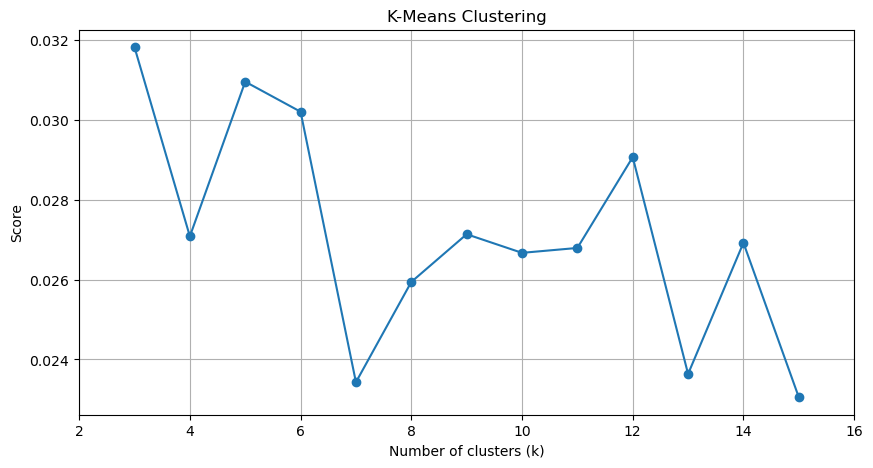

In [85]:
# Assuming cluster_results_km['k'] and cluster_results_km['score'] are your data
plt.figure(figsize=(10, 5))
plt.plot(cluster_results_km['k'], cluster_results_km['score'], marker='o', linestyle='-')
plt.xlim(2, 16)
# Add title and labels
plt.title('K-Means Clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

# Add grid
plt.grid(True)

# Show plot
plt.show()

In [93]:
num_cluster = 3
km_model = KMeans(n_clusters = num_cluster, init ='k-means++', random_state = 42)
y = km_model.fit_predict(matrix)
combine[f'{num_cluster}_Cluster']=y

/Users/yangzejia/anaconda3/envs/text/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [94]:
combine

,0,v_embedding,Cluster,3_Cluster
0,Does entrepreneurship education in the first y...,"[-0.008451409637928009, 0.0033586297649890184,...",0,1
1,Adapting to constructivist approaches to entre...,"[0.014256583526730537, 0.004288913682103157, 0...",4,0
2,Active entrepreneurship education and the impa...,"[0.009077167138457298, 0.02005642093718052, 0....",4,0
3,Nurturing Entrepreneurial Spirit Through Integ...,"[-0.01472783088684082, 0.01929645612835884, 0....",0,1
4,Developing entrepreneurial behaviours in the C...,"[-0.00040966836968436837, -0.00694393552839756...",4,0
...,...,...,...,...
447,The effect of entrepreneur mentoring and its d...,"[-0.0062180496752262115, 0.0036392933689057827...",1,1
448,What's new in the research on agricultural ent...,"[-0.011482832953333855, 0.0021173979621380568,...",0,1
449,Towards a more integrated view of entrepreneur...,"[-0.019980620592832565, 0.019933383911848068, ...",0,0
450,The formation of youth entrepreneurial intenti...,"[-0.009015019983053207, 0.025102421641349792, ...",0,1


### Visualization With k = 5?

Text(0, 0.5, 'Axis 2')

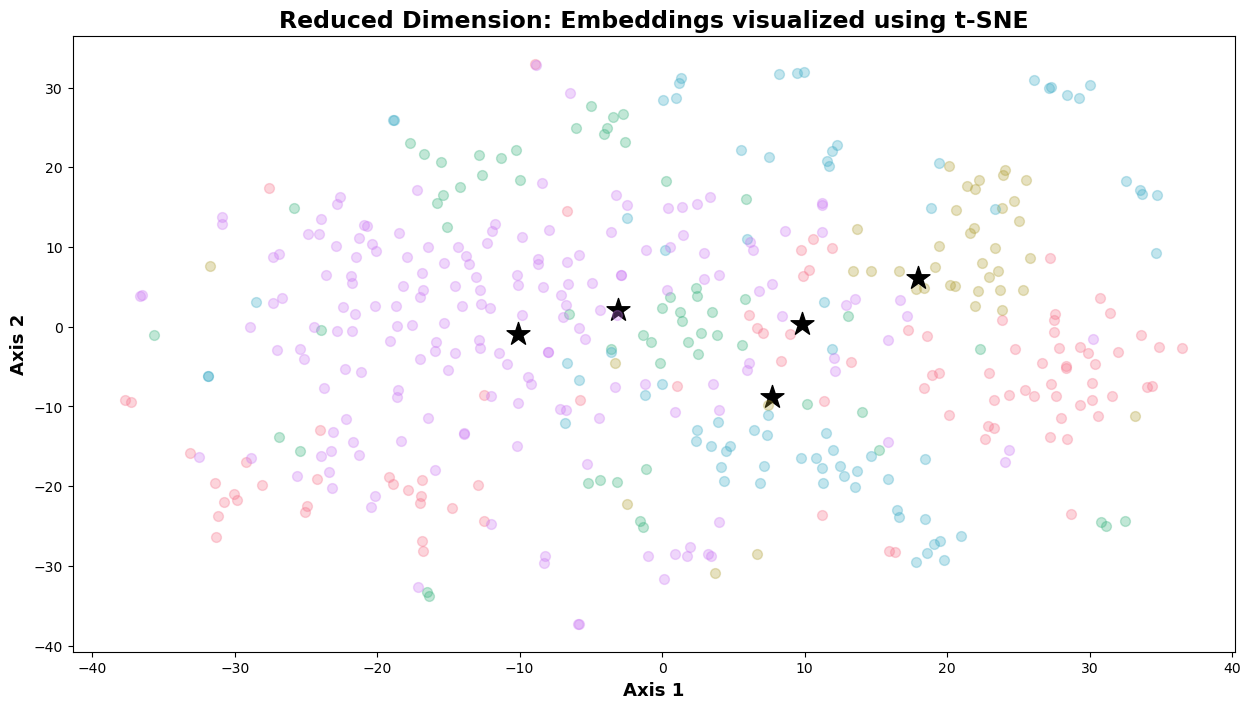

In [92]:
plt.rcParams['figure.figsize'] = (15, 8) 

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x,y in vis_dims2]
y = [y for x,y in vis_dims2]

#palette = sns.color_palette("inferno", num_cluster).as_hex() 
palette = sns.color_palette("husl", num_cluster).as_hex()

for category, color in enumerate(palette):
    xs = np.array(x)[combine[f'{num_cluster}_Cluster']==category]
    ys = np.array(y)[combine[f'{num_cluster}_Cluster']==category]
    plt.scatter(xs, ys, color=color, alpha=0.3, s=50)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.scatter(avg_x, avg_y, marker='*', color='black', s=300)
plt.title("Reduced Dimension: Embeddings visualized using t-SNE", size=17, fontweight="bold")
plt.xlabel('Axis 1',size=13, fontweight="bold")
plt.ylabel('Axis 2',size=13, fontweight="bold")